In [1]:
# Importing some python libraries.
import numpy as np
from numpy.random import randn,rand
import matplotlib.pyplot as pl

from matplotlib.pyplot import plot

import seaborn as sns
%matplotlib inline

# Fixing figure sizes
from pylab import rcParams
rcParams['figure.figsize'] = 10,5



sns.set_palette('Reds_r')

/home/kostis/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Reaction Network Homework

In this homework, we will study a very simple set of reactions by modelling it through three different ways. First, we shall employ an ODE model called the **Reaction Rate Equation**.  Then, we will solve the **Chemical Langevin Equation** and, finally, we will simulate the exact model by "solving" the **Chemical  Master Equation**. 

The reaction network of choice shall be a simple birth-death process, described by the relations : 

$$
\begin{align}
\emptyset \stackrel{a}{\to} X,\\
X \stackrel{\mu X}{\to} \emptyset.
\end{align}
$$

$X$ here is the population number.

## Reaction Rate Equation

The reaction rate equation corresponding to the system is 

$$
\begin{align}
\dot{x}=\mu\cdot x-a,\\
x(0)=x_0.
\end{align}
$$

As this is a linear equation, we can solve it exactly, with solution

$$
x(0)=(x_0-a/\mu)e^{t\mu}+\frac{a}{\mu}
$$

In [14]:
# Solution of the RRE
def x(t,x0=3,a=1,mu=2):
    return (x0-a/mu)*np.exp(t*mu)+a/mu


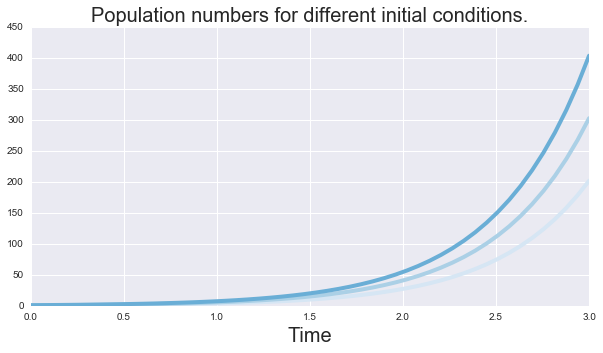

In [17]:
t = np.linspace(0,3)
x0list = np.linspace(0.5,1,3)

sns.set_palette("Blues",n_colors=5)

for x0 in x0list: 
 pl.plot(t,x(t,x0),linewidth=4)

pl.title('Population numbers for different initial conditions.', fontsize=20)
pl.xlabel('Time',fontsize=20)

Comments about figure above...

# Chemical Langevin Equation

Next, we will model the system by using the CLE. For our particular birth/death process, this will be 

$$
dX_t=(a-\mu\cdot X_t)dt+(\sqrt{a}-\sqrt{\mu\cdot X_t})dW.
$$

To solve this, we shall use the Euler-Maruyama scheme from the previous homework. We fix a $\Delta t$ positive. Then, the scheme shall be : 

$$
X_{n+1}=X_n+(a-\mu\cdot X_n)\Delta t+(\sqrt{a}-\sqrt{\mu\cdot X_t})\cdot \sqrt{\Delta t}\cdot z,\ z\sim N(0,1).
$$

In [4]:
def EM(xinit,T,Dt=0.1,a=1,mu=2):
    '''
        Returns the solution of the CLE with parameters a, mu
        
        Arguments
        =========
        xinit : real, initial condition.
        Dt    : real, stepsize of the Euler-Maruyama.
        T     : real, final time to reach.
        a     : real, parameter of the RHS. 
        mu    : real, parameter of the RHS.
    
    '''
    
    n = int(T/Dt) # number of steps to reach T
    X = np.zeros(n)
    z = randn(n)
    
    X[0] = xinit # Initial condition
    
    # EM method 
    for i in xrange(1,n):
        X[i] = X[i-1] + Dt* (a-mu*X[i-1])+(np.sqrt(a)-np.sqrt(mu*X[i-1]))*np.sqrt(Dt)*z[i]
        
    return X
        

Similarly to the previous case, here is a run with multiple initial conditions. 

Paths decay towards 0.525751303558


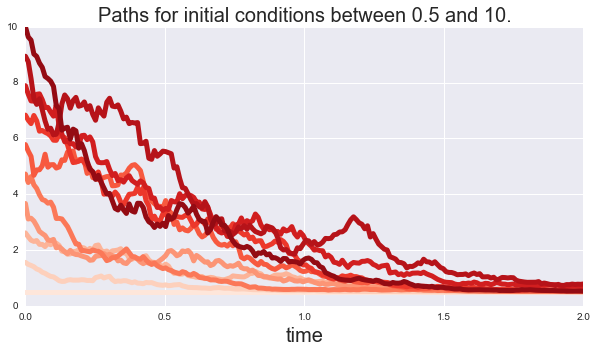

In [13]:
T = 2
Dt = 0.01

sns.set_palette('Reds',10)

def plotPaths(T,Dt):
    n = int(T/Dt)
    t = np.linspace(0,T,n)

    xinitlist = np.linspace(0.5,10,10)

    for x0 in xinitlist : 
        path = EM(xinit=x0,T=T,Dt=Dt,a=1,mu=2.0)
        pl.plot(t, path,linewidth=5)

    pl.xlabel('time', fontsize=20)
    pl.title('Paths for initial conditions between 0.5 and 10.', fontsize=20)
    
    return path
    
path = plotPaths(T,Dt)

print 'Paths decay towards', path[199]


## Chemical Master Equation

Finally, we shall simulate the system exactly by using the Stochastic Simulation Algorithm (SSA). 

In [6]:
def SSA(xinit, nsteps, a=1.0, mu=2.0):
    '''
        Using SSA to exactly simulate the death/birth process starting
        from xinit and for nsteps. 
        
        a and mu are parameters of the propensities.
        
        Returns
        =======
        path : array-like, the path generated. 
        tpath: stochastic time steps
    '''
    
   
    path = np.zeros(nsteps)
    tpath= np.zeros(nsteps)
    
    path[0] = xinit # initial population
    
    u = rand(2,nsteps) # pre-pick all the uniform variates we need
    
    for i in xrange(1,nsteps):
        
        # The propensities will be normalized
        tot_prop = path[i-1]*mu+a
        prob = path[i-1]*mu/tot_prop # probability of death 
        
        if(u[0,i]<prob):
            # Death 
            path[i] = path[i-1]-1 
        else:
            # Birth
            path[i] = path[i-1]+1
            
        # Time stayed at current state    
        tpath[i] = -np.log(u[1,i])*1/tot_prop
        
       
    tpath = np.cumsum(tpath)
    return path, tpath  

Now that we have SSA setup, we can run multiple paths and compare the results to the previous cases.

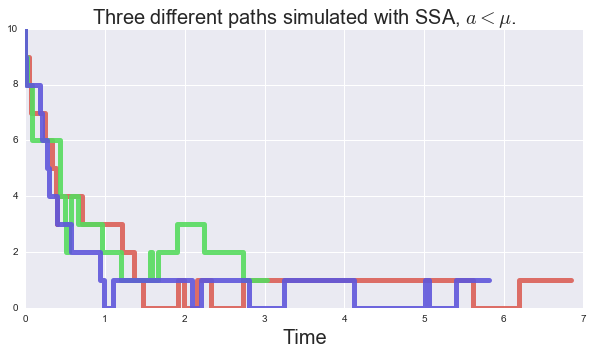

In [7]:
# Since the paths below are not really related
# let's use a more interesting palette 
# for the plot. 

sns.set_palette('hls',3)

for _ in xrange(3):
    path, tpath = SSA(xinit=10,nsteps=20)

    # Since this is the path of a jump process
    # I'm switching from "plot" to "step" 
    # to get the figure right. :) 
    pl.step(tpath,path,linewidth=5,alpha=0.9)

pl.title('Three different paths simulated with SSA, $a<\mu$.', fontsize=20);
pl.xlabel('Time', fontsize=20)



We can see three chains above, all starting from $X_0=10$, and simulated with the SSA. Since the constant that controls the birth rate is smaller than the one controlling the death rate, we see a constant decline of the population in either case.

Expected value of path =  1.18


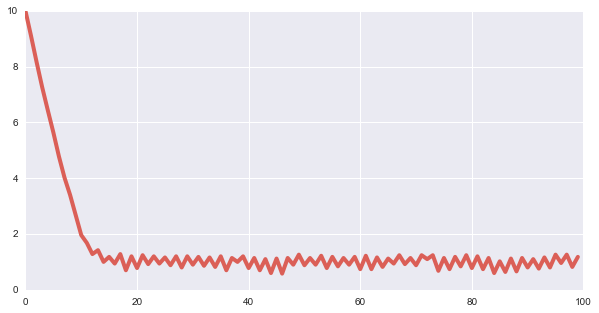

In [8]:
npaths = 100
nsteps = 100

path = np.zeros([npaths,nsteps])
for i in xrange(npaths):
    path[i,:], _ = SSA(xinit=10,nsteps=nsteps)


mean_of_paths = np.mean(path,axis=0)

pl.plot(mean_of_paths, linewidth=4)

print 'Expected value of path = ', mean_of_paths[nsteps-1]